<center>
<h4>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h4>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
 <h2>Mentoría: Detección de objetos en imágenes </h2>
</center>



Esta es una notebook autocontenida para el análisis de datos de la tabla de características de las carpetas de las imágenes del repositorio [Deuba](https://gitlab.com/ciiiutnfrc/deuba) propuesto para la mentoría *'Detección de objetos en imágenes'*.

Para detalles como se encontró la tabla que vamos a utilizar, revisen la notebook [0_DetecciónObjetos_ArmandoLaTabla.ipynb](0_DetecciónObjetos_ArmandoLaTabla.ipynb)


<a name="exploratory_data_analysis"></a>
## **Consignas para la materia Aprendisaje Supervisado**

### 1 General 
*FECHA LíMITE DE ENTREGA: 12/09*

Realizar un informe en formato notebook, en la cual se presenten los resultados del análisis realizado. El mismo debe estar pensado para un público técnico pero que desconoce los aspectos propios del problema a resolver (por ejemplo, sus compañer@s de clase).

Se evaluará principalmente la claridad del mensaje presentado, el uso de las herramientas y los conceptos desarrollados durante las clases de la materia "Introducción al Aprendisaje Automático". Asimismo, el mismo debe incluir de manera clara los hallazgos y problemas encontrados y las posibles accionar a tomar.

Se aconseja que el informe tenga una estructura ordenada, clara y fácil de leer. Por ejemplo, podría contar con una introducción a la problemática a resolver, una descripción de los datos a emplear, el desarrollo propiamente dicho de todo el trabajo y las conclusiones que se obtuvieron.



### 2 Consignas de Aprendisaje Supervisado

Esta entrega es una continuación del trabajo anterior, donde se agregan nuevos algoritmos para evaluar en nuestro dataSet. 

Presentar en un archivo jupyter notebook con la resolución detallada de las siguientes consignas:

##### Preparando el dataSet:

Utilizar la configuración del dataset empleada en el trabajo anterior, en lo que respecta al balanceo del dataset. 

  1- Recordar que en nuestro caso podemos realizar clasificación binaria (ccb y csb) . Por lo cual se pueden descartar aquellas columnas categóricas que no sumen al problema y definir como 'target' nuesta columna de interés.

  2- De las variables/características/features numéricas que hayan encontrado en notebooks anteriores, elegir las mas representativas.

##### Explorarción de algoritmos de clasificación: 
 1. Entrenar el modelo sin parámetros y tomarlo como baseline. Revisar documentación para identificar los parámetros correspondientes.

 2. Utilizar CV para encontrar los parámetros para encontrar el mejor modelo de cada uno de ellos. 
 
 3. Graficar la métrica elegida con respecto al cambio de los parámetros en los conjuntos 'test' y 'train'.

 4. Hacer una tabla para comparar los mejores modelos de cada algoritmo.
 
 5. Visualizar los resultados por medio de:
    * Matriz de Confusión
    * Reporte de Clasificación
    * Curvas ROC
 
Explorar los algoritmos:
 * Regresión Logistica 
 * NaiveBayes
 * SVM

Probar luego métodos de [ensemble](https://scikit-learn.org/stable/modules/ensemble.html#ensemble):
 * Random Forest
 * Boosting
 * Luego probar con los modelos mas sensillos, métodos de voting y ver si mejoran los resultados.
Pueden probar [VotingClassifer](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)


Extra si les queda tiempo:
 * Redes neuronales, con las imágenes como datos de entrada. 

 
Automatizar lo mas posible el proceso. 

Recordar de documentar los pasos que están llevando a cabo, comentar el código, plantear inconvenientes y contar lo que encontraron, poner conclusiones :).



### 3 Corriendo la Notebook

Clonar el donde están las imágenes y luego moverse entre las carpetas. 

In [1]:
# acá vamos importando las librerías necesarias 
# y a medida que van surgiendo por necesidad, las van sumando, para mantener un orden y poder ubicarlas rápido
from IPython.display import Image as Imge
import pandas as pd
import numpy as np
import glob

#seguimos agregando librerías necesarias:
#las que no tengan, vayan instalándolas
import cv2
import numpy as np

import matplotlib.pyplot as plt
import PIL
from PIL import Image
from os import path
import os

#from google.colab.patches import cv2_imshow #en Colab!

import seaborn as sns

### Cargando datos

En este caso, removemos también las columnas de _filename_ y _videoname_ porque no queremos que los modelos aprendan de estos parámetros.

In [2]:
df_train = pd.read_csv('dataset/dataSet_train_crop_features_labels.csv', low_memory=False)
df_test  = pd.read_csv('dataset/dataSet_test_crop_features_labels.csv', low_memory=False)

df_clase_ccb = df_train[df_train['clase'] == 'ccb']
df_clase_csb = df_train[df_train['clase'] == 'csb']

df_clase_csb_over = df_clase_csb.sample(df_clase_ccb.shape[0], replace=True)
df_train_balanced = pd.concat([df_clase_ccb, df_clase_csb_over], axis=0)

drop_features = ['xmin', 'xmax', 'ymin', 'ymax','width','height','bb_width','bb_height','use','Unnamed: 0', 'filename', 'videoname']
df_train_balanced = df_train_balanced.drop(drop_features, axis=1)
df_test = df_test.drop(drop_features, axis=1)

In [3]:
df_train_balanced.head(2)

clase        ch_R        ch_G        ch_B        0         1         2  \
75   ccb  128.093872  126.909584  113.631035  0.23332  0.153776  0.004623   
76   ccb  123.265839  126.031456  113.494461  0.35788  0.241869  0.211136   

           3         4         5  ...      2038      2039      2040      2041  \
75  0.360957  0.310477  0.683618  ...  0.375137  1.920585  0.546962  1.109891   
76  0.452160  0.210771  0.659630  ...  0.372351  2.056816  0.502349  0.339482   

        2042      2043      2044      2045      2046      2047  
75  0.882858  0.104544  0.823586  0.228490  0.739440  0.143627  
76  0.450890  0.196720  0.581477  0.105634  0.620929  0.158563  

[2 rows x 2052 columns]

In [4]:
from sklearn.preprocessing import MinMaxScaler

feat_cols = [str(col_name) for col_name in range(2048)] + ['ch_R', 'ch_G', 'ch_B']
X = df_train_balanced[feat_cols]
X_test = df_test[feat_cols]

y = df_train_balanced["clase"].replace({"ccb": 1, "csb": 0})
y_test = df_test["clase"].replace({"ccb": 1, "csb": 0})

def normalize_dataset(X, y):
    # Toma un dataframe de pandas para valores X y un dataframe objetivo y
    # Devuelve un dataframe con valores escalados a MinMaxScaler

    scaler = MinMaxScaler()
    scaler.fit(X)
    normalized_X_np = scaler.transform(X)

    normalized_X = pd.DataFrame(normalized_X_np, columns=X.keys(), index=X.index)
    
    return normalized_X


normalized_X = normalize_dataset(X, y)
normalized_X_test = normalize_dataset(X_test, y_test)

In [5]:
normalized_X.head()

0         1         2         3         4         5         6  \
75  0.155197  0.153122  0.001524  0.196060  0.101448  0.258321  0.492741   
76  0.238050  0.240841  0.069580  0.245598  0.068869  0.249257  0.616041   
77  0.112746  0.187403  0.061056  0.239755  0.013022  0.293906  0.599707   
78  0.243166  0.126328  0.243140  0.133349  0.062389  0.159958  0.314777   
79  0.177682  0.046751  0.137350  0.036568  0.069447  0.158787  0.122944   

           7         8         9  ...      2041      2042      2043      2044  \
75  0.471540  0.277690  0.180989  ...  0.469759  0.282398  0.071714  0.492117   
76  0.530640  0.421464  0.151697  ...  0.143685  0.137628  0.134943  0.347449   
77  0.473479  0.199978  0.117526  ...  0.536110  0.194323  0.097392  0.447248   
78  0.246813  0.658405  0.403656  ...  0.179378  0.305706  0.160851  0.534708   
79  0.430154  0.797666  0.180907  ...  0.164904  0.420009  0.099617  0.119500   

        2045      2046      2047      ch_R      ch_G      ch_B  
75  0.151292  0.283694  0.118042  0.439135  0.519227  0.466998  
76  0.069944  0.237942  0.130317  0.413515  0.514141  0.466219  
77  0.035766  0.271407  0.155631  0.415336  0.509144  0.464382  
78  0.021051  0.344287  0.034905  0.534128  0.492025  0.498951  
79  0.027074  0.178388  0.078709  0.501377  0.458225  0.470466  

[5 rows x 2051 columns]

### Creamos un método para automatizar el cómputo

In [6]:
import time

from sklearn.metrics import classification_report, f1_score, plot_confusion_matrix, plot_roc_curve
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV

In [7]:
def train_models(models, use_grid_search=False, k_best=3):
    k_best_list = []
    for model, params in models:
        print("========")
        print(f"Fitting model: {model.__name__}")
        fit_start = time.time()
        if use_grid_search:
            clf = GridSearchCV(model(), params, n_jobs=-1)
            clf.fit(normalized_X, y)
            print(f"Best model parameters: {clf.best_params_}")
        else:
            clf = model(**params)
            clf.fit(normalized_X, y)
        print(f"Fit completed in {(time.time() - fit_start):.4f}s")
        
        test_predict = clf.predict(normalized_X_test)
        print(classification_report(y_test, test_predict))
        
        # Getting f1 on ccb class as it is minority class here
        model_f1_score = f1_score(y_test, test_predict, pos_label=0)
        k_best_list.append((clf, model_f1_score))
    
    k_best_list = sorted(k_best_list, key=lambda x: x[1], reverse=True)
    k_best_list = [i[0] for i in k_best_list][:k_best]

    print(f"Voting classifier on {k_best} best: {k_best_list}:")
    if use_grid_search:
        params = [(c.best_estimator_.__class__.__name__, c) for c in k_best_list]
    else:
        params = [(c.__class__.__name__, c) for c in k_best_list]
    clf = VotingClassifier(params)
    clf.fit(normalized_X, y)
    test_predict = clf.predict(normalized_X_test)
    print(classification_report(y_test, test_predict))
    
    return clf, k_best_list

In [20]:
def plot_classification_metrics(classifier, grid=None):
    if grid is None:
        fig = plt.figure(figsize=(15, 5))
        grid = fig.add_gridspec(1, 1)[0]
    inner_grid = grid.subgridspec(1, 2)
    axs = inner_grid.subplots()
    
    if type(classifier) == GridSearchCV:
        classifier_name = type(classifier.best_estimator_).__name__
    else:
        classifier_name = type(classifier).__name__

    axs[0].set_title(f"Confusion matrix for {classifier_name}")
    plot_confusion_matrix(classifier, normalized_X_test, y_test, ax=axs[0])

    axs[1].set_title(f"ROC for {classifier_name}")
    plot_roc_curve(classifier, normalized_X_test, y_test, ax=axs[1])


In [9]:
def plot_classifiers(classifiers):
    fig = plt.figure(figsize=(15, 5 * len(classifiers)))
    grid = fig.add_gridspec(len(classifiers), 1)
    for i, clf in enumerate(classifiers):
        plot_classification_metrics(clf, grid=grid[i, 0])
        

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import CategoricalNB, ComplementNB
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier

In [11]:
random_state = 7492

In [12]:
eval_models = [
    (LogisticRegression, {"random_state": random_state}),
    # CategoricalNB,
    (ComplementNB, {}),
    (LinearSVC, {"random_state": random_state}),
    (NuSVC, {"random_state": random_state}),
    (SVC, {"random_state": random_state}),
    (RandomForestClassifier, {"random_state": random_state}),
    # (GradientBoostingClassifier, {}),
    (XGBClassifier, {"random_state": random_state, 'predictor': 'gpu_predictor', "tree_method": "gpu_hist"})
]

voting, best = train_models(eval_models)

Fitting model: LogisticRegression


/home/juan/Development/mentoria2021-grupo-1/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fit completed in 0.6356s
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       113
           1       1.00      0.99      1.00       382

    accuracy                           0.99       495
   macro avg       0.99      1.00      0.99       495
weighted avg       0.99      0.99      0.99       495

Fitting model: ComplementNB
Fit completed in 0.0248s
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       113
           1       0.97      0.99      0.98       382

    accuracy                           0.97       495
   macro avg       0.97      0.95      0.96       495
weighted avg       0.97      0.97      0.97       495

Fitting model: LinearSVC


/home/juan/Development/mentoria2021-grupo-1/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Fit completed in 0.8358s
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       113
           1       1.00      0.99      1.00       382

    accuracy                           0.99       495
   macro avg       0.99      1.00      0.99       495
weighted avg       0.99      0.99      0.99       495

Fitting model: NuSVC
Fit completed in 3.7256s
              precision    recall  f1-score   support

           0       0.99      0.86      0.92       113
           1       0.96      1.00      0.98       382

    accuracy                           0.97       495
   macro avg       0.97      0.93      0.95       495
weighted avg       0.97      0.97      0.96       495

Fitting model: SVC
Fit completed in 0.6686s
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       113
           1       0.99      0.99      0.99       382

    accuracy                           0.99       495
   macro avg 

/home/juan/Development/mentoria2021-grupo-1/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:20:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fit completed in 3.6312s
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       113
           1       0.99      1.00      0.99       382

    accuracy                           0.99       495
   macro avg       0.99      0.98      0.99       495
weighted avg       0.99      0.99      0.99       495

Voting classifier on 3 best: [LogisticRegression(random_state=7492), LinearSVC(random_state=7492), SVC(random_state=7492)]:


/home/juan/Development/mentoria2021-grupo-1/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/juan/Development/mentoria2021-grupo-1/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


              precision    recall  f1-score   support

           0       0.97      1.00      0.99       113
           1       1.00      0.99      1.00       382

    accuracy                           0.99       495
   macro avg       0.99      1.00      0.99       495
weighted avg       0.99      0.99      0.99       495



In [13]:
plot_classifiers(best)
plt.show()

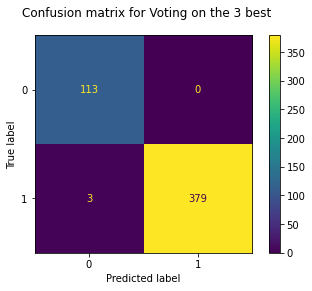

In [14]:
plot_confusion_matrix(voting, normalized_X_test, y_test)
plt.suptitle("Confusion matrix for Voting on the 3 best")
plt.show()

## Usando Grid Search con cross validation

In [15]:
logistic_regression_params = {
    "random_state": [random_state],
    "penalty": ["l2", "elasticnet"],
    "dual": [True, False],
    "tol": [1e-4, 1e-5, 1e-3],
    "C": [0.5, 0.8, 1, 1.3],
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
    "n_jobs": [1]
}

complement_nb_params = {
    "alpha": [0, 0.33, 0.6, 0.8, 1],
    "norm": [True, False]
}

linear_svc_params = {
    "random_state": [random_state],
    "penalty": ["l2", "l1"],
    "dual": [True, False],
    "tol": [1e-4, 1e-5, 1e-3],
    "C": [0.5, 0.8, 1, 1.3],
    "loss": ["hinge", "squared_hinge"],
    "fit_intercept": [True, False],
    "max_iter": [10000]
}

svc_params = {
    "random_state": [random_state],
    "tol": [1e-4, 1e-5, 1e-3],
    "C": [0.5, 0.8, 1, 1.3],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "shrinking": [True, False],
    "probability": [True],
}

xgb_params = {
    "random_state": [random_state],
    "max_depth": [5, 6],
    "learning_rate": [0.0001, 0.01, 0.1, 0.3],
    "gamma": [0.25, 0.3, 1, 5],
    "min_child_weight": [1, 2, 5],
    "reg_lambda": [1, 0.7, 1.3],
    "subsample": [0.8, 1],
    "colsample_bytree": [0.6, 1],
    "eval_metric": ["auc", "logloss"],
    "predictor": ["gpu_predictor"],
    "tree_method": ["gpu_hist"],
    "n_jobs": [1]
}

eval_models = [
    (LogisticRegression, logistic_regression_params),
    (ComplementNB, complement_nb_params),
    (LinearSVC, linear_svc_params),
    (SVC, svc_params),
    (XGBClassifier, xgb_params)
]

voting, best = train_models(eval_models, use_grid_search=True)

Fitting model: LogisticRegression


/home/juan/Development/mentoria2021-grupo-1/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
 0.98528405 0.98528405 0.98528405        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.98563431 0.98563431 0.98563431 0.98563431 0.98563431 0.98563431
 0.98528405 0.98528405 0.98528405 0.98528405 0.98528405 0.98528405
 0.98563431 0.98563431 0.98493317        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.98598458 0.98598458 0.98598458        nan        nan        nan
        nan       

Best model parameters: {'C': 1.3, 'dual': False, 'n_jobs': 1, 'penalty': 'l2', 'random_state': 7492, 'solver': 'saga', 'tol': 0.0001}
Fit completed in 202.7484s
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       113
           1       1.00      0.99      1.00       382

    accuracy                           0.99       495
   macro avg       0.99      1.00      0.99       495
weighted avg       0.99      0.99      0.99       495

Fitting model: ComplementNB
Best model parameters: {'alpha': 0.8, 'norm': False}
Fit completed in 1.3621s
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       113
           1       0.97      0.99      0.98       382

    accuracy                           0.97       495
   macro avg       0.97      0.95      0.96       495
weighted avg       0.97      0.97      0.97       495

Fitting model: LinearSVC


/home/juan/Development/mentoria2021-grupo-1/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.98738686 0.98738686 0.98738686        nan        nan        nan
 0.98738686 0.98738686 0.98738686        nan        nan        nan
 0.98738686 0.98738686 0.98738686        nan        nan        nan
 0.98738686 0.98738686 0.98738686        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.98738686 0.98738686 0.98668572 0.98563554 0.98563554 0.98423449
        nan        nan        nan        nan        nan        nan
 0.98703659 0.98738686 0.98703536 0.98633607 0.98563554 0.98458475
 0.98738686 0.98738686 0.98738686        nan        nan        nan
 0.98738686 0.98738686 0.98738686        nan        nan        nan
 0.98738686 0.98738686 0.98738686        nan        nan        nan
 0.98738686 0.98738686 0.98738686        nan        nan        nan
        nan       

Best model parameters: {'C': 0.5, 'dual': True, 'fit_intercept': True, 'loss': 'hinge', 'max_iter': 10000, 'penalty': 'l2', 'random_state': 7492, 'tol': 0.0001}
Fit completed in 208.6517s
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       113
           1       1.00      0.99      1.00       382

    accuracy                           0.99       495
   macro avg       0.99      1.00      0.99       495
weighted avg       0.99      0.99      0.99       495

Fitting model: SVC
Best model parameters: {'C': 1.3, 'kernel': 'rbf', 'probability': True, 'random_state': 7492, 'shrinking': True, 'tol': 0.0001}
Fit completed in 1482.8889s
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       113
           1       0.99      0.99      0.99       382

    accuracy                           0.99       495
   macro avg       0.99      0.99      0.99       495
weighted avg       0.99      0.99     

/home/juan/Development/mentoria2021-grupo-1/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(
/home/juan/Development/mentoria2021-grupo-1/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Best model parameters: {'colsample_bytree': 0.6, 'eval_metric': 'auc', 'gamma': 0.25, 'learning_rate': 0.0001, 'max_depth': 5, 'min_child_weight': 1, 'n_jobs': 1, 'predictor': 'gpu_predictor', 'random_state': 7492, 'reg_lambda': 1, 'subsample': 0.8, 'tree_method': 'gpu_hist'}
Fit completed in 614.3398s
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       113
           1       0.99      0.99      0.99       382

    accuracy                           0.99       495
   macro avg       0.98      0.98      0.98       495
weighted avg       0.99      0.99      0.99       495

Voting classifier on 3 best: [GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.5, 0.8, 1, 1.3], 'dual': [True, False],
                         'n_jobs': [1], 'penalty': ['l2', 'elasticnet'],
                         'random_state': [7492],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
          

/home/juan/Development/mentoria2021-grupo-1/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
 0.98528405 0.98528405 0.98528405        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.98563431 0.98563431 0.98563431 0.98563431 0.98563431 0.98563431
 0.98528405 0.98528405 0.98528405 0.98528405 0.98528405 0.98528405
 0.98563431 0.98563431 0.98493317        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.98598458 0.98598458 0.98598458        nan        nan        nan
        nan       

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       113
           1       1.00      0.99      1.00       382

    accuracy                           0.99       495
   macro avg       0.99      1.00      0.99       495
weighted avg       0.99      0.99      0.99       495



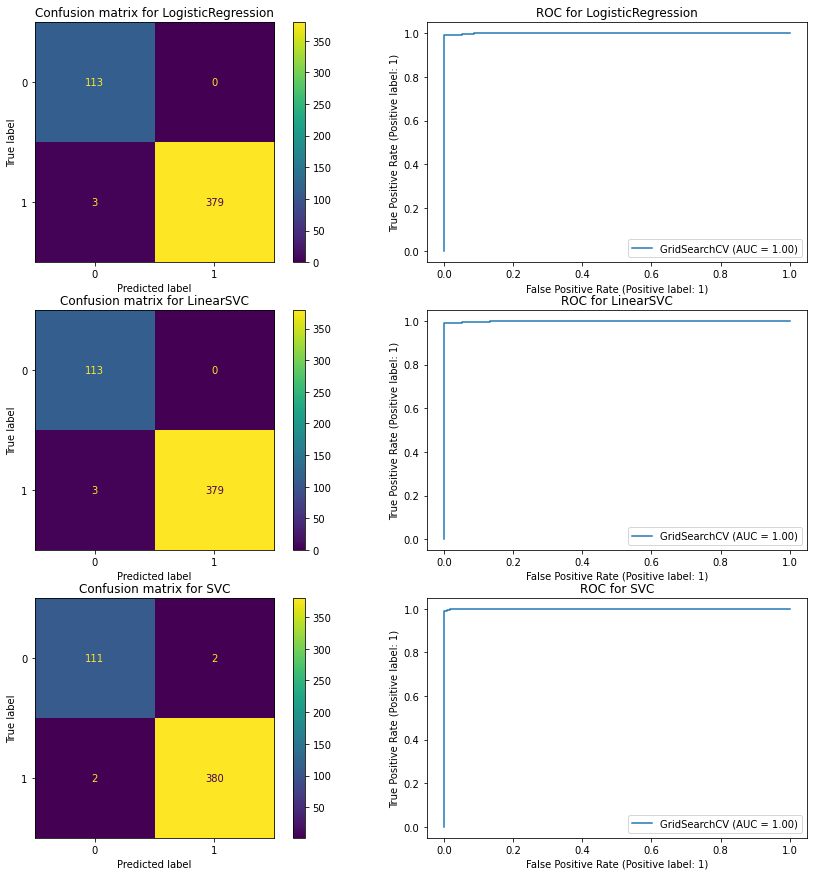

In [21]:
plot_classifiers(best)

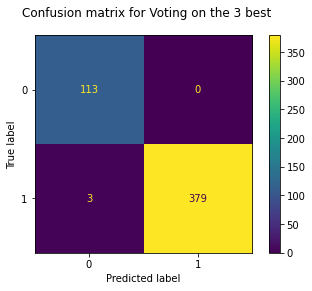

In [17]:
plot_confusion_matrix(voting, normalized_X_test, y_test)
plt.suptitle("Confusion matrix for Voting on the 3 best")
plt.show()

## Tabla comparativa de los valores obtenidos por GridSearchCV en cada modelo

In [18]:
def grid_search_compare_table(models):
    accum_df = None
    for model in best:
        model_df = pd.DataFrame(model.cv_results_)
        model_df["model"] = type(model.best_estimator_).__name__
        drop_cols = [col for col in model_df.columns if col.startswith("param_")]
        model_df.drop(columns=drop_cols, inplace=True)
        if accum_df is None:
            accum_df = model_df
        else:
            accum_df = pd.concat([accum_df, model_df], axis=0)
    accum_df.sort_values(by="mean_test_score", ascending=False, inplace=True)
    accum_df.reset_index(drop=True, inplace=True)
    
    return accum_df

In [22]:
grid_search_compare_table(best).head(20)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       41.541375      2.884559         1.883503        1.099055   
1       40.660666      2.034563         1.738163        0.866231   
2       40.443010      2.284242         1.536281        1.045620   
3       40.736120      2.420667         1.653499        0.984963   
4       40.332420      2.745095         1.345928        0.896149   
5       41.301299      2.788418         2.368248        0.339596   
6       42.109573      0.634328         1.505856        0.801689   
7       43.779485      0.978002         2.554038        0.428572   
8       42.034509      1.332772         2.000298        0.626109   
9       42.375311      2.228230         2.343107        0.291854   
10      40.850528      1.882897         1.038098        0.784317   
11      41.987737      4.026548         1.894028        0.491771   
12      44.880214      2.473710         0.563508        0.330812   
13      42.925792      2.351852         2.177342        0.307835   
14      44.447147      3.255880         2.327539        0.557598   
15      44.137297      2.948155         2.611282        0.707179   
16      43.941964      1.976092         1.831116        0.492607   
17      42.934662      3.049080         2.295969        0.631322   
18       9.904452      1.470476         0.029916        0.017238   
19      12.594797      3.878820         0.038748        0.019192   

                                               params  split0_test_score  \
0   {'C': 1.3, 'kernel': 'rbf', 'probability': Tru...                1.0   
1   {'C': 1.3, 'kernel': 'rbf', 'probability': Tru...                1.0   
2   {'C': 1.3, 'kernel': 'rbf', 'probability': Tru...                1.0   
3   {'C': 1.3, 'kernel': 'rbf', 'probability': Tru...                1.0   
4   {'C': 1.3, 'kernel': 'rbf', 'probability': Tru...                1.0   
5   {'C': 1.3, 'kernel': 'rbf', 'probability': Tru...                1.0   
6   {'C': 1, 'kernel': 'rbf', 'probability': True,...                1.0   
7   {'C': 1, 'kernel': 'rbf', 'probability': True,...                1.0   
8   {'C': 1, 'kernel': 'rbf', 'probability': True,...                1.0   
9   {'C': 1, 'kernel': 'rbf', 'probability': True,...                1.0   
10  {'C': 1, 'kernel': 'rbf', 'probability': True,...                1.0   
11  {'C': 1, 'kernel': 'rbf', 'probability': True,...                1.0   
12  {'C': 0.8, 'kernel': 'rbf', 'probability': Tru...                1.0   
13  {'C': 0.8, 'kernel': 'rbf', 'probability': Tru...                1.0   
14  {'C': 0.8, 'kernel': 'rbf', 'probability': Tru...                1.0   
15  {'C': 0.8, 'kernel': 'rbf', 'probability': Tru...                1.0   
16  {'C': 0.8, 'kernel': 'rbf', 'probability': Tru...                1.0   
17  {'C': 0.8, 'kernel': 'rbf', 'probability': Tru...                1.0   
18  {'C': 0.8, 'dual': False, 'fit_intercept': Fal...                1.0   
19  {'C': 1, 'dual': True, 'fit_intercept': False,...                1.0   

    split1_test_score  split2_test_score  split3_test_score  \
0            0.985989           0.987741           0.985989   
1            0.985989           0.987741           0.985989   
2            0.985989           0.987741           0.985989   
3            0.985989           0.987741           0.985989   
4            0.985989           0.987741           0.985989   
5            0.985989           0.987741           0.985989   
6            0.985989           0.984238           0.985989   
7            0.985989           0.984238           0.985989   
8            0.985989           0.984238           0.985989   
9            0.985989           0.984238           0.985989   
10           0.985989           0.984238           0.985989   
11           0.985989           0.984238           0.985989   
12           0.985989           0.982487           0.984238   
13           0.985989           0.982487           0.984238   
14           0.985989           0

Tabla 1: Tabla de comparación de modelos y métricas.  

### Notas
- Se usó XGBoost en lugar de GradientBoosting para aprovechar la GPU. Los resultados fueron equivalentes.
- Es difícil de mejorar el resultado con Voting, dado el buen resultado de los modelos seleccionados.
- Se usó f1 sobre la clase minoritaria (ccb) para la comparación de los modelos.


### Conclusiones

- Para este estudio se empleó un modo automatizado para generar las métricas de los diferentes modelos y técnicas de modo ordenado.
- Se estudiaron las curvas ROC de los diferentes modelos propuestos y las matrices de confusión de los mismos. 
- Todos os modelos generaron metricas con valores altos. En el caso de los 3 primeros mayores a 0.98. 
- Como se puede observar en la tablal mejor modelo obtenido fue con SVC.
